In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import re
import time
import os
from datetime import datetime, timedelta


%matplotlib inline

### Reading initial dataset

In [2]:
df_train = pd.read_csv('../input/kuzushiji-recognition/train.csv')
unicode_map = {codepoint: char for codepoint, char in 
               pd.read_csv('../input/kuzushiji-recognition/unicode_translation.csv').values}

### A bit of statistics

In [3]:
def convert_labels_set(labels_str):
    labels = []
    for one_label_str in re.findall(r'U\+\S+\s\S+\s\S+\s\S+\s\S+', labels_str):
        charcode, x, y, w, h = one_label_str.split(' ')
        labels.append([charcode, int(x), int(y), int(w), int(h)])
    return labels

In [4]:
n_labels = 0
chars_counts = {}

for labels_set in df_train.values[:, 1]:
    if type(labels_set) is not str:
        continue

    labels = convert_labels_set(labels_set)
    n_labels += len(labels)
    for label in labels:
        try:
            chars_counts[label[0]] += 1
        except KeyError:
            chars_counts.update({label[0]: 1})

chars_counts_list = [chars_counts[k] for k in chars_counts]
n_classes = len([k for k in chars_counts])

print('Number of labels:                  {}'.format(n_labels))
print('Number of classes:                 {}'.format(n_classes))
print('Min max number of items per class: {} {}'.format(np.min(chars_counts_list), np.max(chars_counts_list)))
print('Median number of items per class:  {}'.format(np.median(chars_counts_list)))
print('Mean number of items per class:    {}'.format(np.mean(chars_counts_list)))

Number of labels:                  683464
Number of classes:                 4212
Min max number of items per class: 1 24685
Median number of items per class:  9.0
Mean number of items per class:    162.26590693257359


### Making dataset

In [5]:
def get_char_images_from_sheet(src_image_path, labels_str, blur_kernel_size=3, img_size=64):
    src_img = cv2.imread(src_image_path, cv2.IMREAD_COLOR)

    char_imgs, labels_codes = [], []
    for label in convert_labels_set(labels_str):
        char_img = np.zeros((img_size, img_size), dtype=np.uint8)
        charcode, x, y, w, h = label

        label_img = src_img[y:y + h, x:x + w, :]
        label_img = cv2.GaussianBlur(label_img, 
                                     (blur_kernel_size, blur_kernel_size), 
                                     cv2.BORDER_DEFAULT)
        label_img = cv2.cvtColor(label_img, cv2.COLOR_RGB2GRAY)
        _, label_img = cv2.threshold(label_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        label_img = 255 - label_img
        
        if w > h:
            label_img = cv2.resize(label_img, (img_size, int(img_size * h / w)))
            dy = int((img_size - int(img_size * h / w)) / 2)
            char_img[dy:dy + int(img_size * h / w), :] += label_img
        
        else:
            label_img = cv2.resize(label_img, (int(img_size * w / h), img_size))            
            dx = int((img_size - int(img_size * w / h)) / 2)
            char_img[:, dx:dx + int(img_size * w / h)] += label_img
        
        char_imgs.append(char_img)
        labels_codes.append(charcode)
    return char_imgs, labels_codes

In [6]:
img_size = 64
generator_out_depth = 64

chars_imgs = []
chars_labels = []

for value in df_train.values:
    img_filename, labels_str = value
    try:
        imgs, labels = get_char_images_from_sheet('../input/kuzushiji-recognition/train_images/{}.jpg'.format(img_filename), labels_str, img_size=img_size)
    except TypeError:
#         print('Unable to parse {}'.format(labels_str))
        continue
    chars_imgs.extend(imgs)
    chars_labels.extend(labels)

In [7]:
chars_imgs = np.array(chars_imgs)
np.min(chars_imgs), np.max(chars_imgs), chars_imgs.shape

(0, 255, (683464, 64, 64))

### DCGAN: The simplest example

In [8]:
from tensorflow.keras import layers
import tensorflow as tf

In [45]:
generator_out_depth = 8
discriminator_in_depth = 16
noise_dim = 50


#### Generator

In [46]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense((img_size / 4) * (img_size / 4) * generator_out_depth * 4, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 
    model.add(layers.Reshape((int(img_size / 4), int(img_size / 4), generator_out_depth * 4)))
    assert model.output_shape == (None, img_size / 4, img_size / 4, generator_out_depth * 4) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(generator_out_depth * 2, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, img_size / 4, img_size / 4, generator_out_depth * 2)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(generator_out_depth, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, img_size / 2, img_size / 2, generator_out_depth)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, img_size, img_size, 1)

    return model

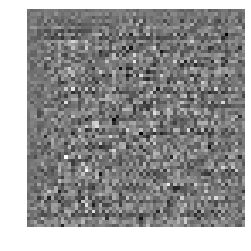

In [47]:
generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

### Discriminator

In [48]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(discriminator_in_depth, (5, 5), strides=(2, 2), padding='same', input_shape=[img_size, img_size, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(discriminator_in_depth * 2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [49]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00467879]], shape=(1, 1), dtype=float32)


## Losses

In [50]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [51]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimisers

In [52]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Training loop

In [53]:
checkpoint_dir = '../working/dcgan_chekpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [54]:
EPOCHS = 100
BATCH_SIZE = 4096
checkpoints_step = 10

# noise_dim = 50
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [55]:
def convert_images_to_tf(images):
    out_images = (images - 127.5).astype('float32') / 127.5
    out_images = out_images.reshape(images.shape[0], img_size, img_size, 1)
    return out_images

In [56]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [57]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('../working/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    

    
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for _ in range(int(dataset.shape[0] / BATCH_SIZE)):
        image_batch = dataset[np.random.choice(range(dataset.shape[0]), BATCH_SIZE)]
        converted_images = convert_images_to_tf(image_batch)
        train_step(converted_images)

    # Produce images for the GIF as we go
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % checkpoints_step == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  generate_and_save_images(generator, epochs, seed)

## Training

In [58]:
train_dataset = chars_imgs

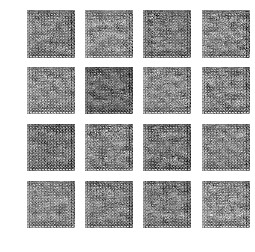

Time for epoch 1 is 57.45774579048157 sec


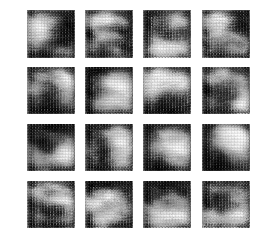

Time for epoch 2 is 53.308579444885254 sec


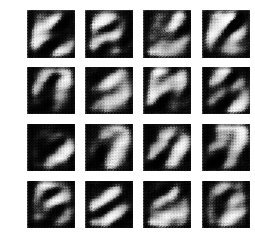

Time for epoch 3 is 52.74751114845276 sec


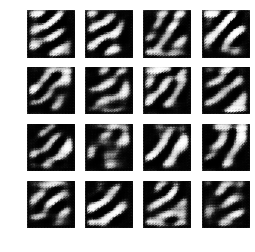

Time for epoch 4 is 54.817383766174316 sec


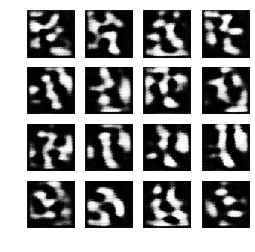

Time for epoch 5 is 54.7965407371521 sec


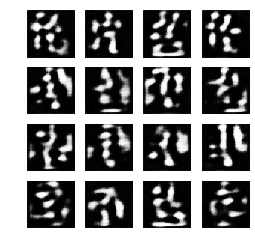

Time for epoch 6 is 52.546746492385864 sec


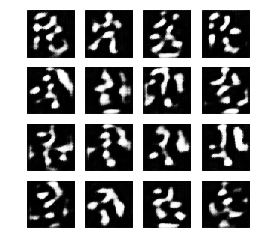

Time for epoch 7 is 55.24609303474426 sec


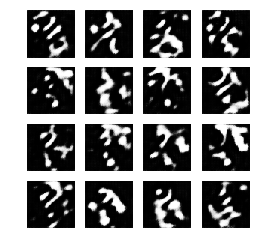

Time for epoch 8 is 53.95214557647705 sec


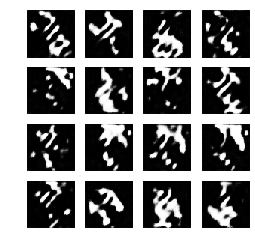

Time for epoch 9 is 51.7952024936676 sec


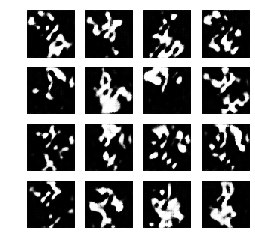

Time for epoch 10 is 55.11431813240051 sec


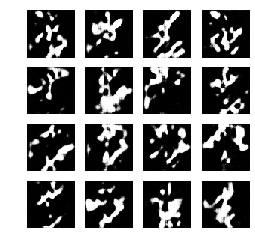

Time for epoch 11 is 52.10978841781616 sec


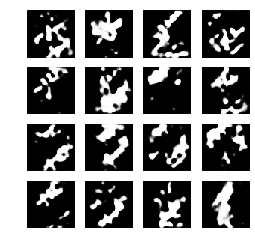

Time for epoch 12 is 51.35576128959656 sec


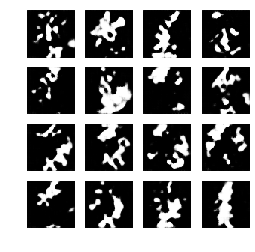

Time for epoch 13 is 53.92596626281738 sec


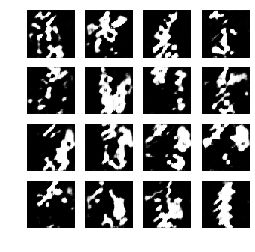

Time for epoch 14 is 55.66833281517029 sec


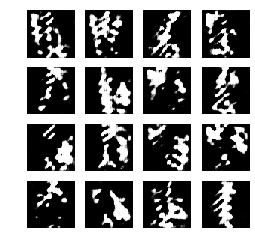

Time for epoch 15 is 56.61295294761658 sec


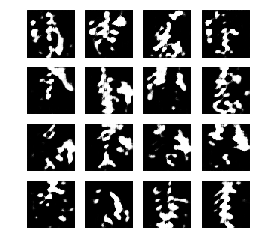

Time for epoch 16 is 56.292670488357544 sec


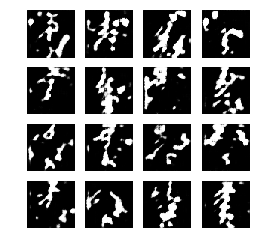

Time for epoch 17 is 56.91282367706299 sec


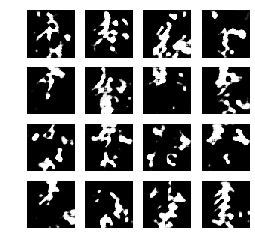

Time for epoch 18 is 53.1652946472168 sec


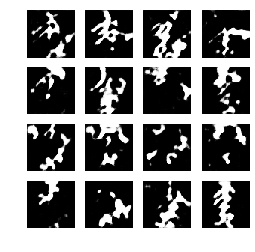

Time for epoch 19 is 50.66982293128967 sec


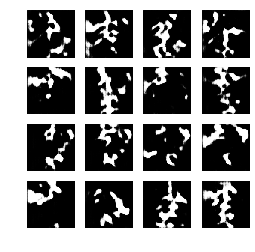

Time for epoch 20 is 52.13252234458923 sec


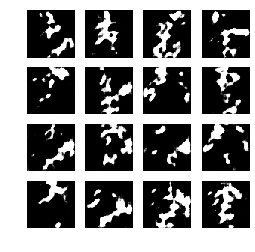

Time for epoch 21 is 52.37456154823303 sec


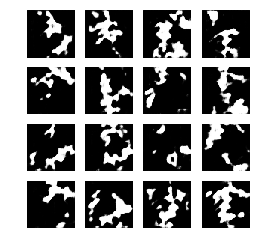

Time for epoch 22 is 52.1478374004364 sec


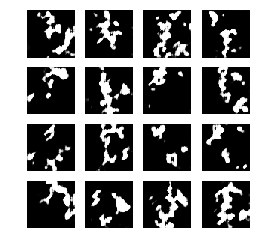

Time for epoch 23 is 53.1307110786438 sec


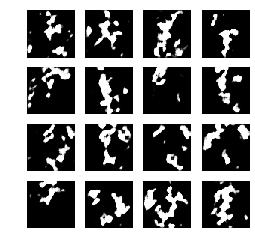

Time for epoch 24 is 54.2154381275177 sec


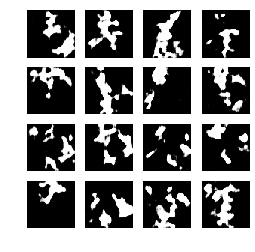

Time for epoch 25 is 54.13045001029968 sec


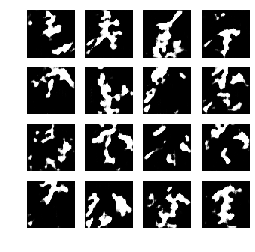

Time for epoch 26 is 54.47625136375427 sec


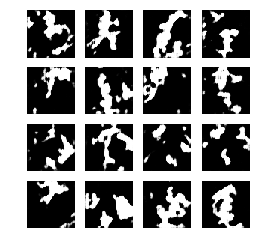

Time for epoch 27 is 52.72521233558655 sec


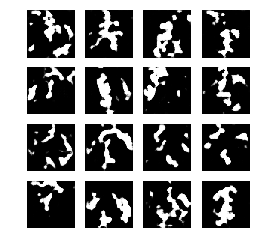

Time for epoch 28 is 51.993770360946655 sec


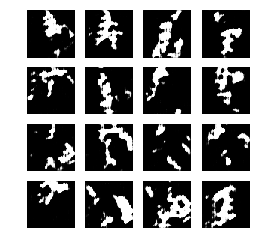

Time for epoch 29 is 51.97227692604065 sec


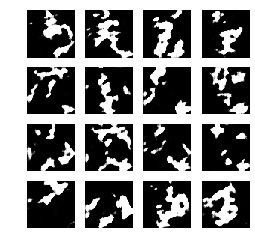

Time for epoch 30 is 49.835793256759644 sec


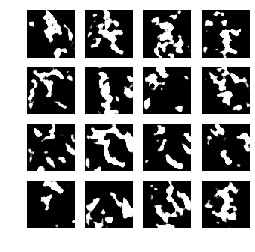

Time for epoch 31 is 52.076669692993164 sec


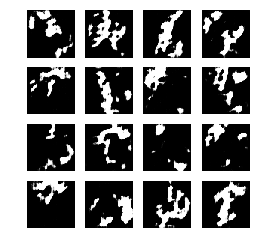

Time for epoch 32 is 50.799487829208374 sec


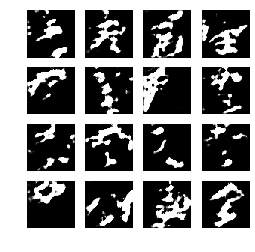

Time for epoch 33 is 52.60166525840759 sec


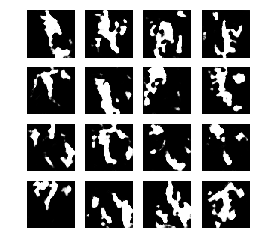

Time for epoch 34 is 53.114253520965576 sec


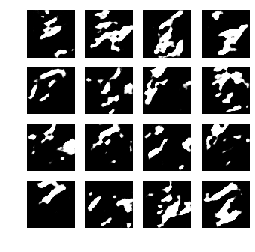

Time for epoch 35 is 51.399784088134766 sec


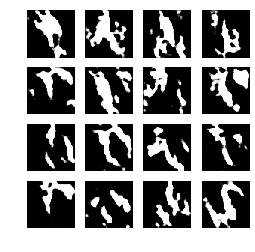

Time for epoch 36 is 51.55803108215332 sec


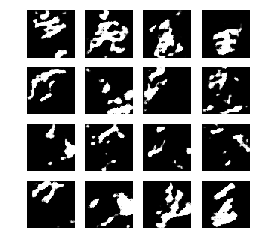

Time for epoch 37 is 52.84835147857666 sec


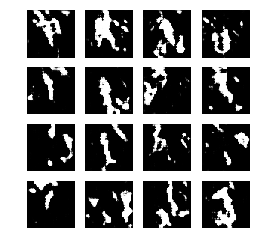

Time for epoch 38 is 50.8498318195343 sec


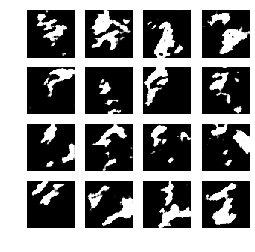

Time for epoch 39 is 51.5586473941803 sec


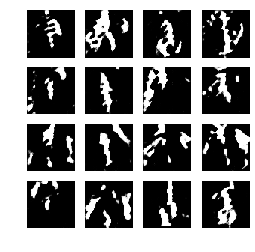

Time for epoch 40 is 53.57852125167847 sec


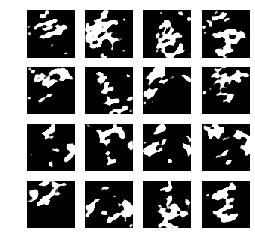

Time for epoch 41 is 53.597684144973755 sec


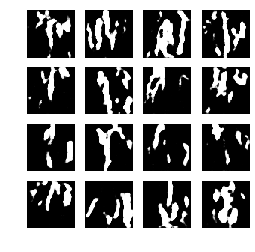

Time for epoch 42 is 54.25478005409241 sec


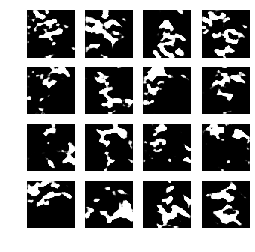

Time for epoch 43 is 52.037466049194336 sec


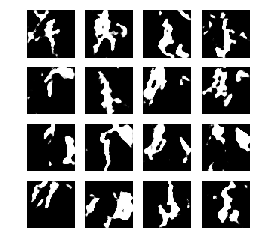

Time for epoch 44 is 52.24271774291992 sec


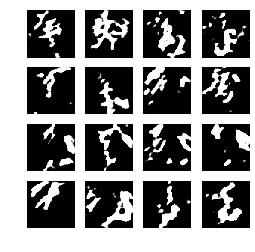

Time for epoch 45 is 50.800387144088745 sec


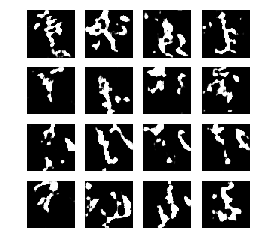

Time for epoch 46 is 50.51099371910095 sec


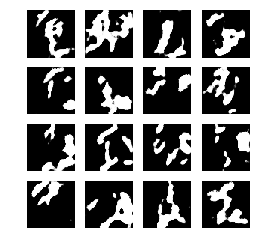

Time for epoch 47 is 52.40813326835632 sec


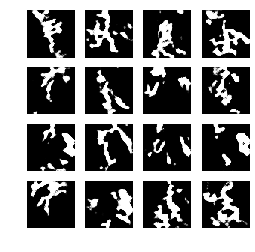

Time for epoch 48 is 54.209677934646606 sec


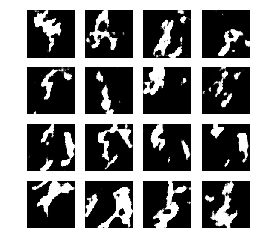

Time for epoch 49 is 55.43998146057129 sec


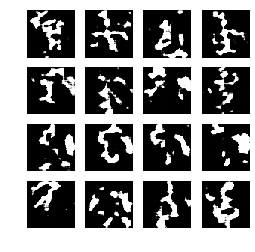

Time for epoch 50 is 58.08364725112915 sec


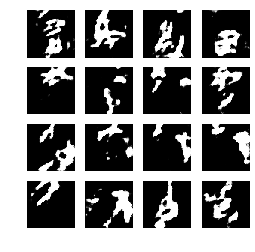

Time for epoch 51 is 51.31670427322388 sec


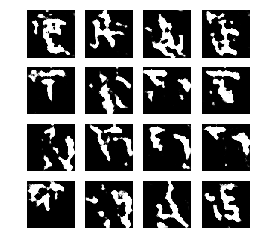

Time for epoch 52 is 51.517587423324585 sec


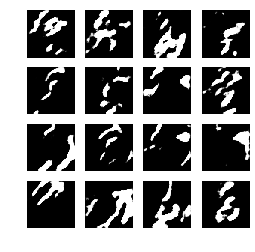

Time for epoch 53 is 52.53806829452515 sec


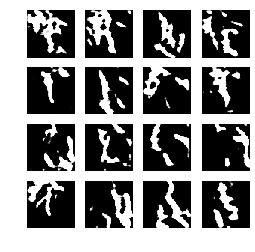

Time for epoch 54 is 51.57413864135742 sec


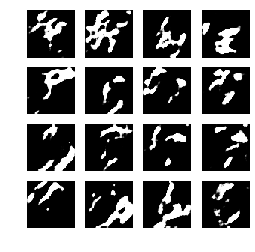

Time for epoch 55 is 52.2956805229187 sec


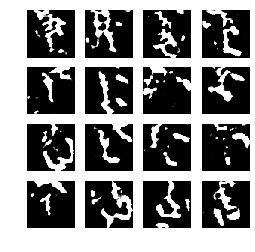

Time for epoch 56 is 51.81396770477295 sec


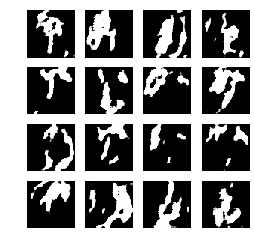

Time for epoch 57 is 54.10640335083008 sec


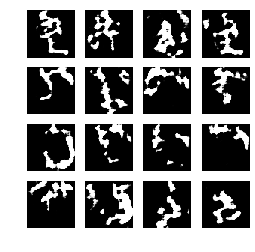

Time for epoch 58 is 54.57602787017822 sec


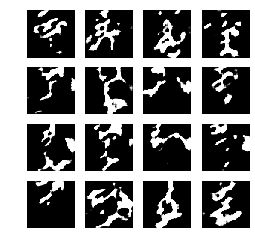

Time for epoch 59 is 50.35361385345459 sec


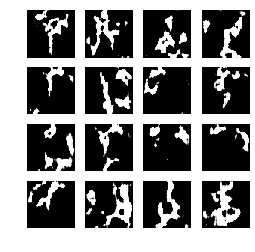

Time for epoch 60 is 50.97411584854126 sec


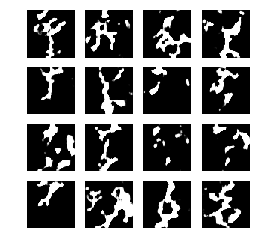

Time for epoch 61 is 52.51387166976929 sec


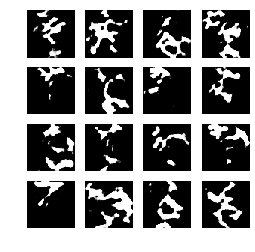

Time for epoch 62 is 52.490811824798584 sec


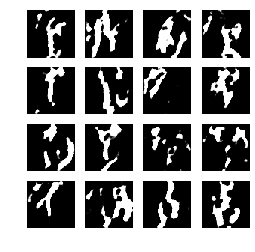

Time for epoch 63 is 52.317105770111084 sec


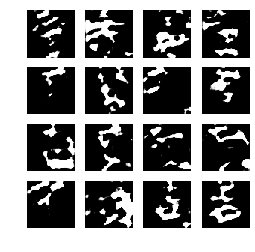

Time for epoch 64 is 53.48650860786438 sec


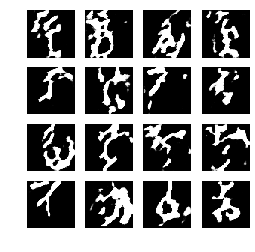

Time for epoch 65 is 54.64360475540161 sec


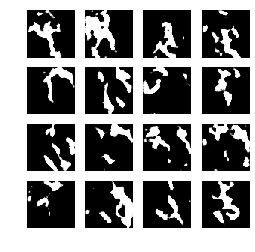

Time for epoch 66 is 53.15602469444275 sec


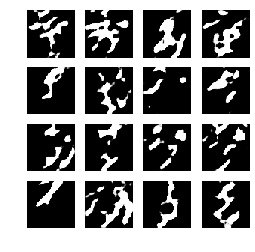

Time for epoch 67 is 51.083199977874756 sec


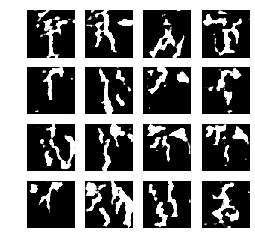

Time for epoch 68 is 50.39424395561218 sec


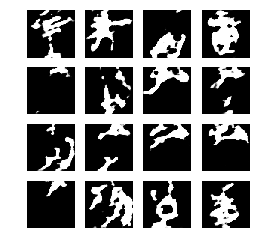

Time for epoch 69 is 51.63933277130127 sec


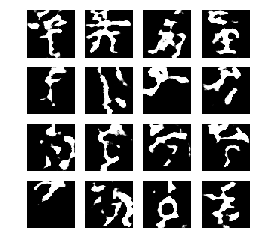

Time for epoch 70 is 50.73030066490173 sec


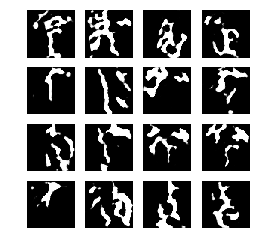

Time for epoch 71 is 50.4634895324707 sec


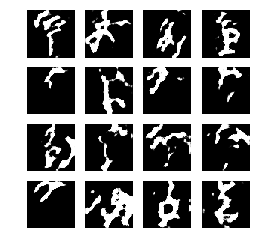

Time for epoch 72 is 50.583667278289795 sec


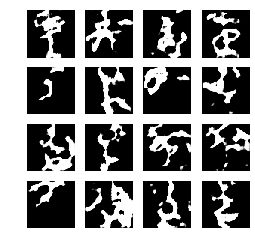

Time for epoch 73 is 52.85320067405701 sec


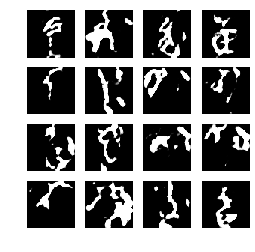

Time for epoch 74 is 54.226123332977295 sec


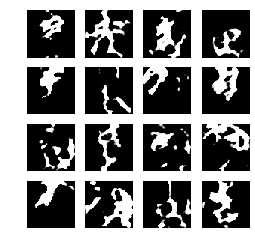

Time for epoch 75 is 51.173057079315186 sec


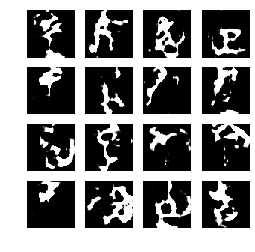

Time for epoch 76 is 51.22043180465698 sec


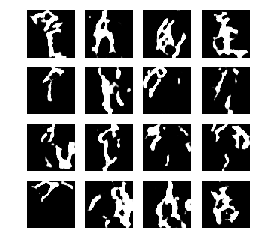

Time for epoch 77 is 51.035844802856445 sec


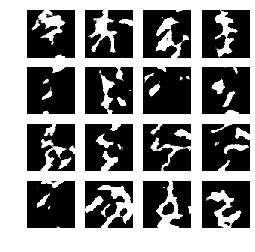

Time for epoch 78 is 50.22276997566223 sec


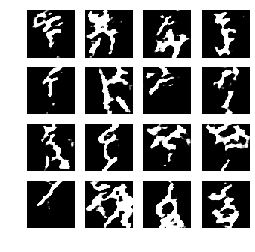

Time for epoch 79 is 51.65937066078186 sec


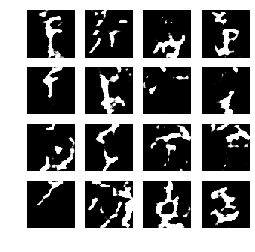

Time for epoch 80 is 53.55730485916138 sec


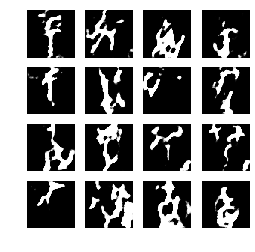

Time for epoch 81 is 53.35709071159363 sec


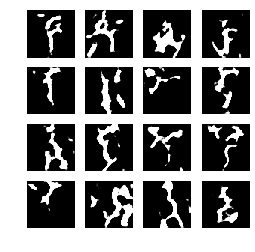

Time for epoch 82 is 57.21382284164429 sec


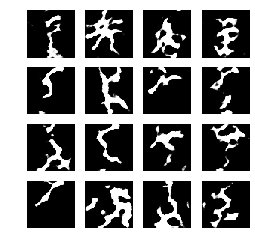

Time for epoch 83 is 50.953975677490234 sec


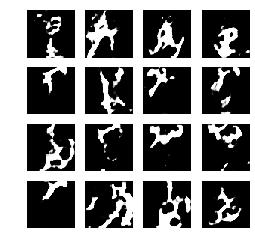

Time for epoch 84 is 52.574655294418335 sec


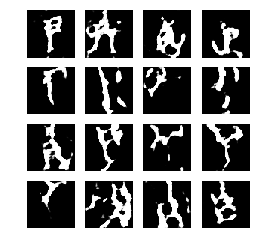

Time for epoch 85 is 51.63455820083618 sec


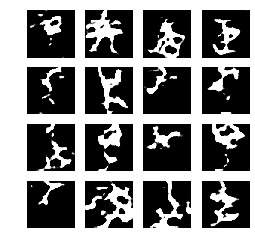

Time for epoch 86 is 51.514915466308594 sec


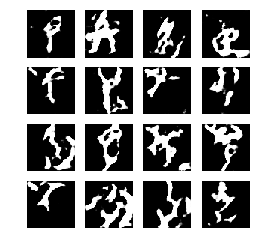

Time for epoch 87 is 53.15049934387207 sec


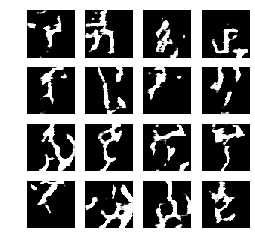

Time for epoch 88 is 50.02994394302368 sec


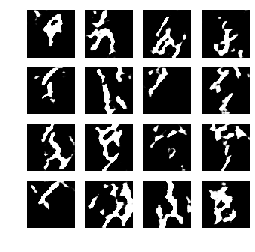

Time for epoch 89 is 51.58184051513672 sec


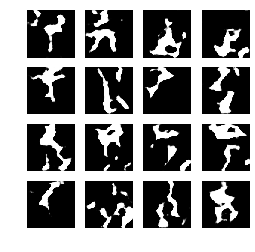

Time for epoch 90 is 55.09446382522583 sec


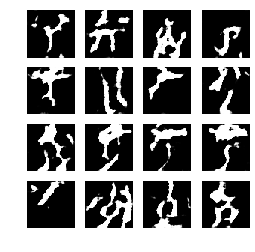

Time for epoch 91 is 51.8075270652771 sec


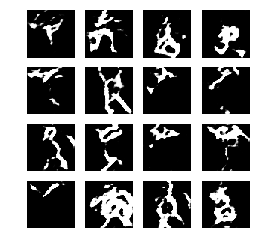

Time for epoch 92 is 51.550349712371826 sec


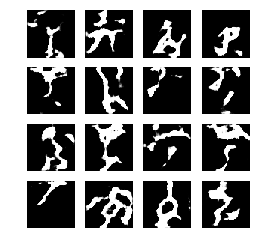

Time for epoch 93 is 52.806524991989136 sec


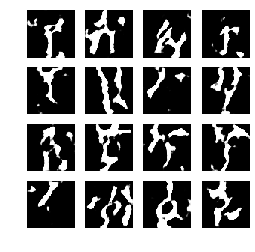

Time for epoch 94 is 51.57043218612671 sec


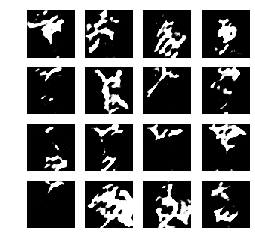

Time for epoch 95 is 52.53428554534912 sec


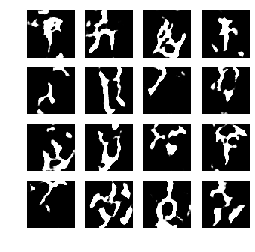

Time for epoch 96 is 54.17463755607605 sec


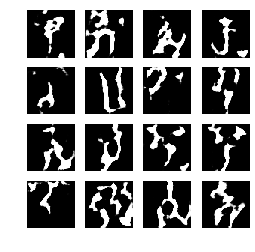

Time for epoch 97 is 53.4598171710968 sec


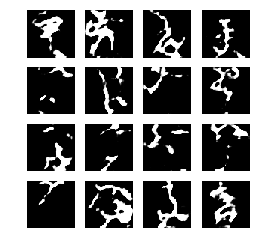

Time for epoch 98 is 54.806050539016724 sec


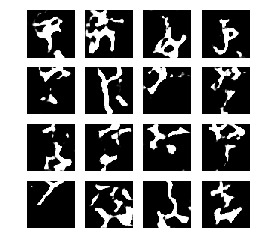

Time for epoch 99 is 49.79385304450989 sec


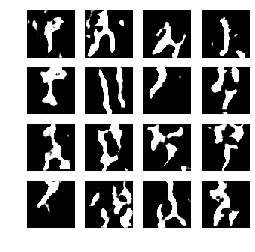

Time for epoch 100 is 50.69365310668945 sec


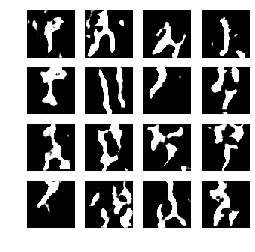

CPU times: user 1h 16min 27s, sys: 11min 3s, total: 1h 27min 31s
Wall time: 1h 27min 53s


In [59]:
%%time
train(train_dataset, EPOCHS)

## An attempt to save data

In [63]:
from subprocess import check_output
# print(check_output(["ls", "-lah", "../working"]).decode("utf8"))
# print(check_output(["ls", "../working/dcgan_chekpoints"]).decode("utf8"))

In [64]:
import zipfile

In [66]:
with zipfile.ZipFile('../working/porgress_at_images.zip', 'w') as imgs_zip:
    for i in range(1, 101):
        imgs_zip.write('../working/image_at_epoch_0{:03d}.png'.format(i))

In [67]:
with zipfile.ZipFile('../working/nns_checkpoints.zip', 'w') as checkpoints_zip:
    for filename in check_output(["ls", "../working/dcgan_chekpoints"]).decode("utf8").split('\n'):
        checkpoints_zip.write('../working/dcgan_chekpoints/{}'.format(filename))

In [68]:
from IPython.display import FileLink, FileLinks
# FileLinks('.')

./
  image_at_epoch_0051.png
  nns_checkpoints.zip
  image_at_epoch_0063.png
  image_at_epoch_0007.png
  image_at_epoch_0015.png
  image_at_epoch_0020.png
  image_at_epoch_0032.png
  __notebook_source__.ipynb
  image_at_epoch_0026.png
  image_at_epoch_0065.png
  image_at_epoch_0052.png
  image_at_epoch_0054.png
  image_at_epoch_0100.png
  image_at_epoch_0097.png
  image_at_epoch_0036.png
  image_at_epoch_0046.png
  image_at_epoch_0099.png
  image_at_epoch_0096.png
  image_at_epoch_0041.png
  image_at_epoch_0067.png
  image_at_epoch_0056.png
  image_at_epoch_0019.png
  image_at_epoch_0042.png
  image_at_epoch_0086.png
  image_at_epoch_0018.png
  image_at_epoch_0039.png
  image_at_epoch_0025.png
  image_at_epoch_0027.png
  image_at_epoch_0075.png
  image_at_epoch_0087.png
  image_at_epoch_0010.png
  image_at_epoch_0043.png
  image_at_epoch_0009.png
  image_at_epoch_0044.png
  image_at_epoch_0045.png
  image_at_epoch_0078.png
  image_at_epoch_0068.png
  image_at_epoch_0016.png
  image_at_epoch_0077.png
  image_at_epoch_0076.png
  image_at_epoch_0053.png
  image_at_epoch_0006.png
  image_at_epoch_0090.png
  image_at_epoch_0048.png
  image_at_epoch_0073.png
  image_at_epoch_0013.png
  image_at_epoch_0004.png
  image_at_epoch_0011.png
  image_at_epoch_0031.png
  image_at_epoch_0029.png
  image_at_epoch_0003.png
  image_at_epoch_0049.png
  image_at_epoch_0014.png
  image_at_epoch_0047.png
  image_at_epoch_0057.png
  image_at_epoch_0061.png
  image_at_epoch_0022.png
  image_at_epoch_0093.png
  image_at_epoch_0055.png
  image_at_epoch_0089.png
  image_at_epoch_0002.png
  image_at_epoch_0066.png
  image_at_epoch_0035.png
  image_at_epoch_0088.png
  image_at_epoch_0008.png
  image_at_epoch_0062.png
  image_at_epoch_0069.png
  image_at_epoch_0091.png
  image_at_epoch_0033.png
  image_at_epoch_0037.png
  image_at_epoch_0017.png
  image_at_epoch_0098.png
  image_at_epoch_0030.png
  image_at_epoch_0070.png
  image_at_epoch_0034.png
  image_at_epoch_0040.png
  image_at_epoch_0001.png
  image_at_epoch_0080.png
  porgress_at_images.zip
  image_at_epoch_0059.png
  image_at_epoch_0071.png
  image_at_epoch_0005.png
  image_at_epoch_0038.png
  image_at_epoch_0079.png
  image_at_epoch_0082.png
  image_at_epoch_0050.png
  image_at_epoch_0095.png
  image_at_epoch_0060.png
  image_at_epoch_0064.png
  image_at_epoch_0023.png
  image_at_epoch_0021.png
  image_at_epoch_0074.png
  image_at_epoch_0084.png
  image_at_epoch_0012.png
  image_at_epoch_0081.png
  image_at_epoch_0072.png
  image_at_epoch_0092.png
  image_at_epoch_0094.png
  image_at_epoch_0058.png
  image_at_epoch_0083.png
  image_at_epoch_0028.png
  image_at_epoch_0085.png
  image_at_epoch_0024.png
./.ipynb_checkpoints/
  __notebook_source__-checkpoint.ipynb
./dcgan_chekpoints/
  ckpt-8.data-00000-of-00002
  ckpt-2.data-00000-of-00002
  ckpt-3.index
  ckpt-9.data-00001-of-00002
  ckpt-4.data-00000-of-00002
  ckpt-7.data-00000-of-00002
  ckpt-6.index
  ckpt-5.data-00000-of-00002
  ckpt-6.data-00000-of-00002
  ckpt-1.index
  checkpoint
  ckpt-5.index
  ckpt-8.data-00001-of-00002
  ckpt-9.index
  ckpt-3.data-00000-of-00002
  ckpt-2.index
  ckpt-8.index
  ckpt-4.data-00001-of-00002
  ckpt-5.data-00001-of-00002
  ckpt-9.data-00000-of-00002
  ckpt-1.data-00001-of-00002
  ckpt-10.data-00001-of-00002
  ckpt-1.data-00000-of-00002
  ckpt-7.data-00001-of-00002
  ckpt-3.data-00001-of-00002
  ckpt-7.index
  ckpt-10.index
  ckpt-6.data-00001-of-00002
  ckpt-2.data-00001-of-00002
  ckpt-4.index
  ckpt-10.data-00000-of-00002